In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
import shapely.geometry as shp

Premier etape faire un circuit

Ref : *Spline_continuity.py* from PythonRobotics

In [5]:
class Spline2D:

    def __init__(self, x, y, kind="cubic"):
        self.s = self.__calc_s(x, y)
        self.sx = interpolate.interp1d(self.s, x, kind=kind)
        # self.sx = interpolate.lagrange(self.s, x)
        self.sy = interpolate.interp1d(self.s, y, kind=kind)
        #self.sy = interpolate.lagrange(self.s, y)

    def __calc_s(self, x, y):
        self.ds = np.hypot(np.diff(x), np.diff(y))
        s = [0.0]
        s.extend(np.cumsum(self.ds))
        return s

    def calc_position(self, s):
        x = self.sx(s)
        y = self.sy(s)
        return x, y

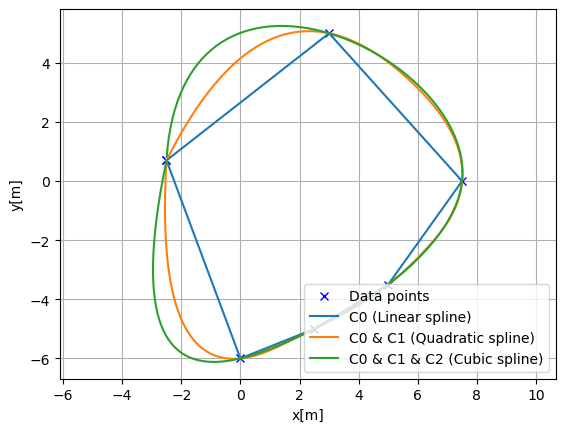

In [6]:
x = [-2.5, 0.0, 2.5, 5.0, 7.5, 3.0, -2.5]
y = [0.7, -6, -5, -3.5, 0.0, 5.0, 0.7]
ds = 0.1  # [m] distance of each interpolated points

plt.subplots(1)
plt.plot(x, y, "xb", label="Data points")

for (kind, label) in [("linear", "C0 (Linear spline)"),
                        ("quadratic", "C0 & C1 (Quadratic spline)"),
                        ("cubic", "C0 & C1 & C2 (Cubic spline)")]:
    rx, ry = [], []
    sp = Spline2D(x, y, kind=kind)
    s = np.arange(0, sp.s[-1], ds)
    for i_s in s:
        ix, iy = sp.calc_position(i_s)
        rx.append(ix)
        ry.append(iy)
    plt.plot(rx, ry, "-", label=label)

plt.grid(True)
plt.axis("equal")
plt.xlabel("x[m]")
plt.ylabel("y[m]")
plt.legend(loc='lower right')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


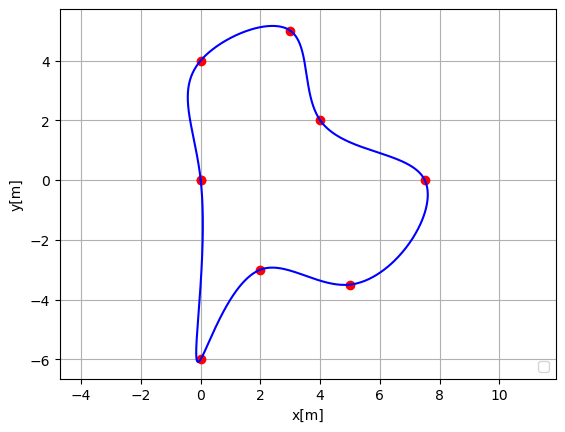

In [10]:
x = [0, 0, 2, 5.0, 7.5, 4.0, 3.0, 0]
y = [0, -6, -3, -3.5, 0.0, 2.0, 5.0, 4]

# Close the circuit
x = np.r_[x, x[0]]
y = np.r_[y, y[0]]
# fit splines to x=f(u) and y=g(u), treating both as periodic. also note that s=0
# is needed in order to force the spline fit to pass through all the input points.
tck,u = interpolate.splprep([x, y], s=0, per=True)

# evaluate the spline fits for 1000 evenly spaced distance values
xi, yi = interpolate.splev(np.linspace(0, 1, 1000), tck)

# plot the result
fig, ax = plt.subplots(1, 1)
ax.plot(x, y, 'or')
ax.plot(xi, yi, '-b')
plt.grid(True)
plt.axis("equal")
plt.xlabel("x[m]")
plt.ylabel("y[m]")
plt.legend(loc='lower right')
plt.show()

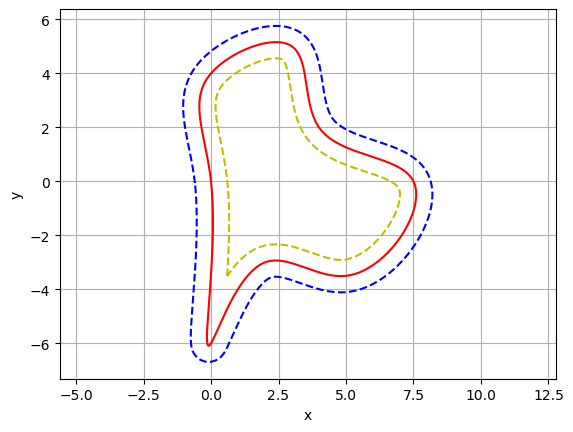

In [11]:
afpoly = shp.Polygon(zip(xi,yi))

poffafpoly = afpoly.buffer(0.6)  # Outward offset
noffafpoly = afpoly.buffer(-0.6)  # Inward offset

afpolypts = np.array(afpoly.exterior)
poffafpolypts = np.array(poffafpoly.exterior)
noffafpolypts = np.array(noffafpoly.exterior)

plt.plot(*afpolypts.T,'-r',)
plt.plot(*poffafpolypts.T, '--b')
plt.plot(*noffafpolypts.T, '--y')


plt.grid(True)
plt.axis("equal")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

TODO : fuction/class qui trans form juste des x,y en circuit
Agrandir le circuit

La longueure de la track est de 32.61 mètre


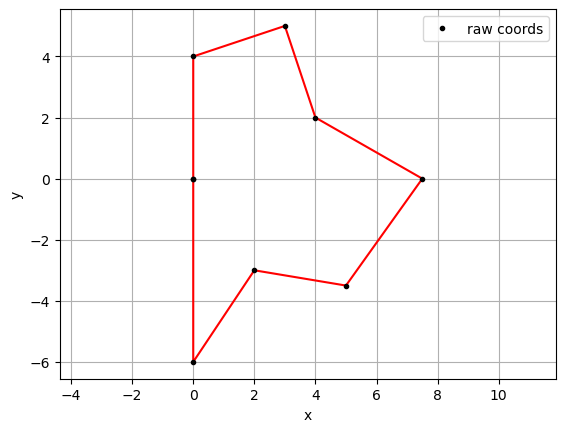

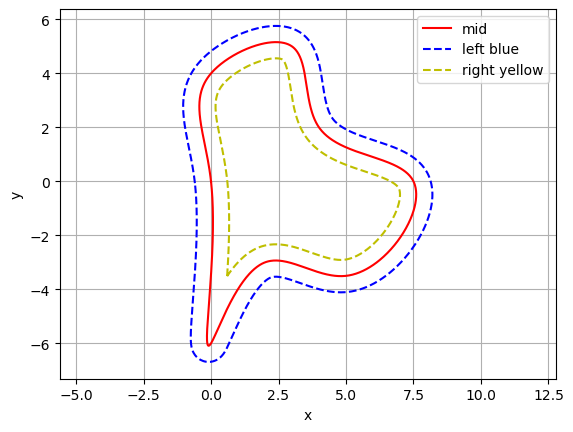

In [54]:
class Track:
    def __init__(self, x, y):
        self.x = np.r_[x, x[0]] #close the track
        self.y = np.r_[y, y[0]]
        self.thickness = 1.5 # thinckness of the track
    
    """
    J'ai choisi de prendre cette interpolation mais on pourrais en prendre une autre si celle la ne nous plait pas
    """
    def interpolation(self, x, y):
        tck,u = interpolate.splprep([x, y], s=0, per=True)
        x_smooth, y_smooth = interpolate.splev(np.linspace(0, 1, 1000), tck)
        self.x_smooth, self.y_smooth = x_smooth, y_smooth
        return(x_smooth, y_smooth)
        
    def poly_track(self): #transforme l'array en shape pour pouvoir faire des manipulation geometrique
        self.interpolation(self.x, self.y)
        return(shp.Polygon(zip(self.x_smooth, self.y_smooth)))
    
    def array_mid(self): # renvoie un array de la ligne mid apres interpolation
        return(np.array(self.poly_track().exterior))
    
    def array_left_corner(self): # renvoie un array de la ligne mid apres interpolation
        return(np.array(self.poly_track().buffer(self.thickness/2).exterior))
    
    def array_right_corner(self): # renvoie un array de la ligne mid apres interpolation
        return(np.array(self.poly_track().buffer(-self.thickness/2).exterior))
    
    def show_poly(self): # permet de show le track sans l'interpolation
        poly_tack_nonsmooth = shp.Polygon(zip(self.x, self.y))
        poly_track_array = np.array(poly_tack_nonsmooth.exterior)
        
        plt.plot(*poly_track_array.T,'r-')
        plt.plot(*poly_track_array.T,'k.',label="raw coords")
        
        plt.grid(True)
        plt.axis("equal")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.legend()
        plt.show()
            
    def show_mid(self):
        poly_track_array = np.array(self.poly_track().exterior)
        
        plt.plot(*poly_track_array.T,'-r',label="mid")
        
        plt.grid(True)
        plt.axis("equal")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.legend()
        plt.show()
        
    def show_exter(self):
        poly_left_corner = self.poly_track().buffer(self.thickness/2)  # Outward offset
        poly_right_corner = self.poly_track().buffer(-self.thickness/2)  # Inward offset
        
        poly_left_corner_array = np.array(poly_left_corner.exterior)
        poly_right_corner_array = np.array(poly_right_corner.exterior)
        
        plt.plot(*poly_left_corner_array.T, '--b', label="left blue")
        plt.plot(*poly_right_corner_array.T, '--y', label="right yellow")
        
        plt.grid(True)
        plt.axis("equal")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.legend()
        plt.show()
        
    def show_track(self):
        poly_left_corner = self.poly_track().buffer(0.6)  # Outward offset
        poly_right_corner = self.poly_track().buffer(-0.6)  # Inward offset
        
        poly_track_array = np.array(self.poly_track().exterior)
        poly_left_corner_array = np.array(poly_left_corner.exterior)
        poly_right_corner_array = np.array(poly_right_corner.exterior)
        
        plt.plot(*poly_track_array.T,'-r', label="mid")
        plt.plot(*poly_left_corner_array.T, '--b', label="left blue")
        plt.plot(*poly_right_corner_array.T, '--y', label="right yellow")
        
        plt.grid(True)
        plt.axis("equal")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.legend()
        plt.show()
        
    def details(self):
        self.lenght = self.poly_track().length
        
        
x = [0, 0, 2, 5.0, 7.5, 4.0, 3.0, 0]
y = [0, -6, -3, -3.5, 0.0, 2.0, 5.0, 4]

T1 = Track(x,y)
T1.details()
print("La longueure de la track est de {lenght:.2f} mètre".format(lenght = T1.lenght))
T1.show_poly()
# display(T1.array_mid())
# display(T1.array_left_corner())
# display(T1.array_right_corner())
T1.show_track()
# T1.show_exter()
# T1.show_mid()

        